In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import utils

In [20]:
WINDOW=7
TIMESERIES_FEATURES=['Close']
DROP = ["Date", "Open", "High", "Low", "Volume"]

INTO_FUTURE=90

In [21]:
COLUMNS = ["Date", "Open", "High", "Low", "Close", "Volume", "Stock"]
OTHER_FEATURES = list(set(COLUMNS) - set(TIMESERIES_FEATURES + DROP))
FEATURE_SIZE = WINDOW * len(TIMESERIES_FEATURES) + len(OTHER_FEATURES)

In [22]:
TIMESTEPS = utils.get_timesteps(WINDOW, TIMESERIES_FEATURES, INTO_FUTURE)

In [23]:
df

,Close,Stock,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
0,0.3888,0,0.3345,0.2916,0.4223,0.3261,0.3303,0.3679,0.4369
1,0.4327,0,0.3888,0.3345,0.2916,0.4223,0.3261,0.3303,0.3679
2,0.3042,0,0.4327,0.3888,0.3345,0.2916,0.4223,0.3261,0.3303
3,0.3407,0,0.3042,0.4327,0.3888,0.3345,0.2916,0.4223,0.3261
4,0.3972,0,0.3407,0.3042,0.4327,0.3888,0.3345,0.2916,0.4223
...,...,...,...,...,...,...,...,...,...
93116,1.2000,21,1.1700,1.3300,1.3200,1.2200,1.1500,1.3600,1.3500
93117,1.2300,21,1.2000,1.1700,1.3300,1.3200,1.2200,1.1500,1.3600
93118,1.3400,21,1.2300,1.2000,1.1700,1.3300,1.3200,1.2200,1.1500
93119,1.2000,21,1.3400,1.2300,1.2000,1.1700,1.3300,1.3200,1.2200


In [5]:
df = utils.load_timeseries_data(
    window=WINDOW, features=TIMESERIES_FEATURES, drop=DROP)
df.head()

,Close,Stock,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
0,0.3888,0,0.3345,0.2916,0.4223,0.3261,0.3303,0.3679,0.4369
1,0.4327,0,0.3888,0.3345,0.2916,0.4223,0.3261,0.3303,0.3679
2,0.3042,0,0.4327,0.3888,0.3345,0.2916,0.4223,0.3261,0.3303
3,0.3407,0,0.3042,0.4327,0.3888,0.3345,0.2916,0.4223,0.3261
4,0.3972,0,0.3407,0.3042,0.4327,0.3888,0.3345,0.2916,0.4223


In [6]:
X_train, y_train, X_valid, y_valid = utils.load_timeseries_data(
    window=WINDOW, features=TIMESERIES_FEATURES, drop=DROP, how="split", label="Close")
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((74487, 8), (74487, 1), (18634, 8), (18634, 1))

In [7]:
train_dataset, valid_dataset = (tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).batch(128).prefetch(tf.data.AUTOTUNE), tf.data.Dataset.from_tensor_slices(
    (X_valid, y_valid)).batch(128).prefetch(tf.data.AUTOTUNE))

In [8]:
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(X_train)

In [9]:
tf.random.set_seed(42)
input = tf.keras.layers.Input(shape=(FEATURE_SIZE))
x = normalizer(input)
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(x)
x = tf.keras.layers.LSTM(128, activation="relu")(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(input, output)

model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam()
)

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=valid_dataset
)

Epoch 1/5
582/582 [==============================] - 8s 11ms/step - loss: 0.5137 - val_loss: 0.6179
Epoch 2/5
582/582 [==============================] - 6s 10ms/step - loss: 0.1669 - val_loss: 0.3728
Epoch 3/5
582/582 [==============================] - 5s 9ms/step - loss: 0.1063 - val_loss: 0.4165
Epoch 4/5
582/582 [==============================] - 5s 9ms/step - loss: 0.0924 - val_loss: 0.4835
Epoch 5/5
582/582 [==============================] - 5s 9ms/step - loss: 0.0930 - val_loss: 0.2379


In [10]:
model.predict(X_valid.iloc[0].to_list()), y_valid.iloc[0]

(array([[1.7723016]], dtype=float32),
 Close    2.0577
 Name: 0, dtype: float64)

In [15]:
# Make forecast into the future
future_forecast = utils.make_future_forecasts(
    model=model,
    into_future=INTO_FUTURE,
    window_size=WINDOW,
    drop=DROP,
    timeseries_features=TIMESERIES_FEATURES
)
future_forecast

{'AHEALTH': [3.1249216,
  3.0030448,
  3.183522,
  3.207357,
  2.9953098,
  3.057706,
  3.1305542,
  3.5096257,
  3.5071807,
  3.636515,
  3.6315637,
  3.520664,
  3.60552,
  3.7491143,
  4.0314817,
  4.0910077,
  4.1903815,
  4.1849537,
  4.1486464,
  4.261809,
  4.4424214,
  4.6805058,
  4.772504,
  4.856485,
  4.863804,
  4.882178,
  5.0226064,
  5.224482,
  5.440994,
  5.548017,
  5.622948,
  5.646087,
  5.7043023,
  5.867083,
  6.0800505,
  6.281052,
  6.3900046,
  6.4561567,
  6.4931073,
  6.5839486,
  6.7627463,
  6.975449,
  7.1577144,
  7.258759,
  7.3180046,
  7.369571,
  7.481322,
  7.6661944,
  7.868542,
  8.027626,
  8.113121,
  8.163611,
  8.223929,
  8.346677,
  8.528208,
  8.711592,
  8.84308,
  8.908553,
  8.949397,
  9.014073,
  9.140204,
  9.310843,
  9.46923,
  9.570804,
  9.615233,
  9.64722,
  9.713693,
  9.837862,
  9.9923525,
  10.122554,
  10.194505,
  10.219738,
  10.245069,
  10.312194,
  10.430848,
  10.566009,
  10.667321,
  10.712153,
  10.721906,
  10.743

In [16]:
stock = utils.load_timeseries_data(
    window=WINDOW, features=TIMESERIES_FEATURES, drop=[], how="dict")

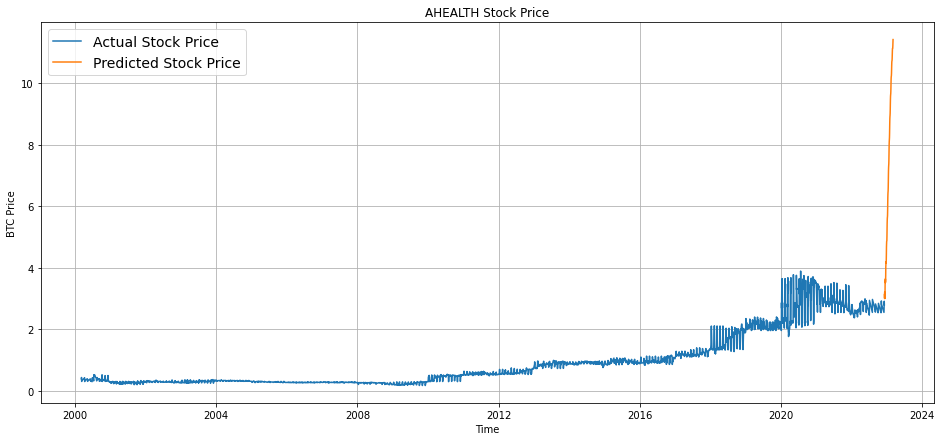

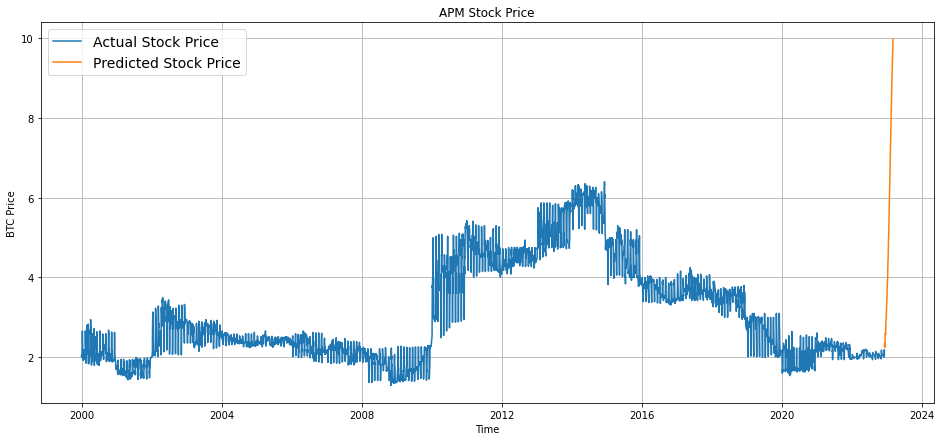

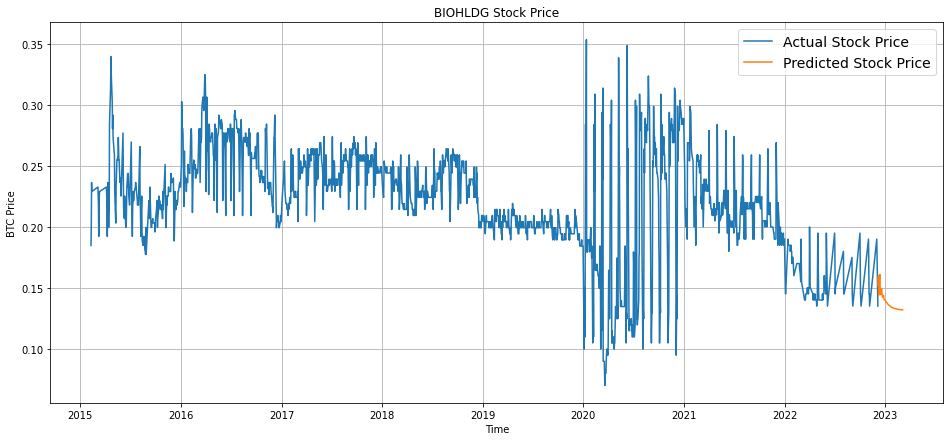

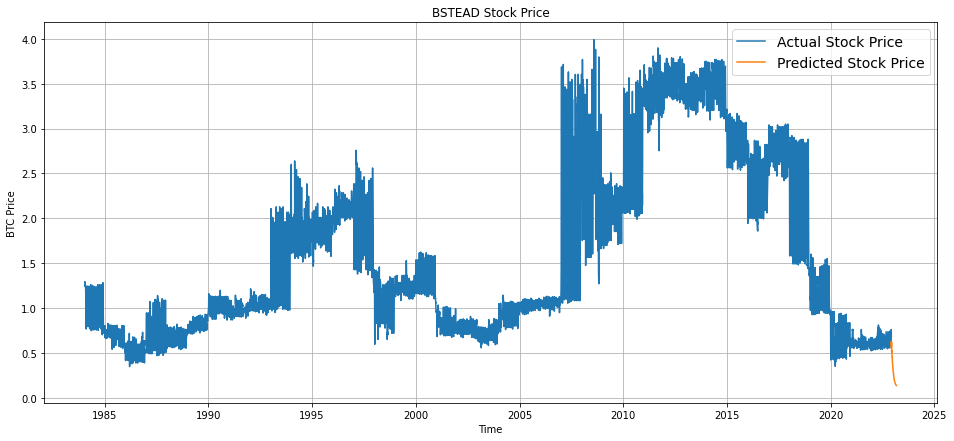

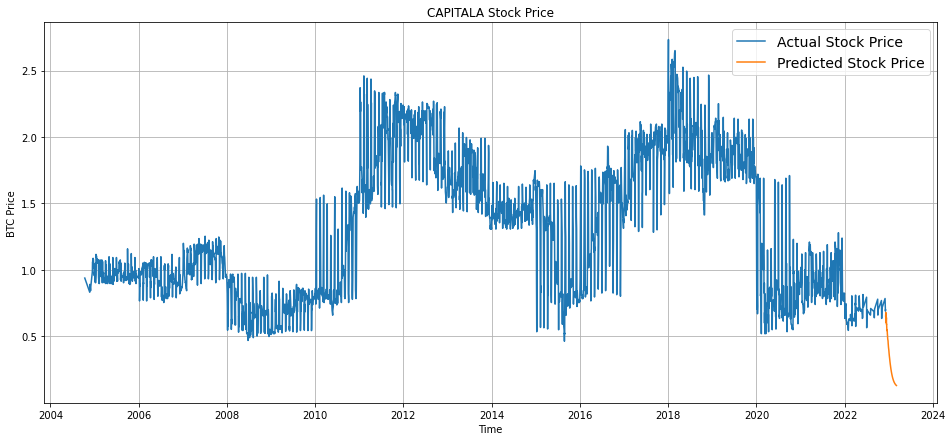

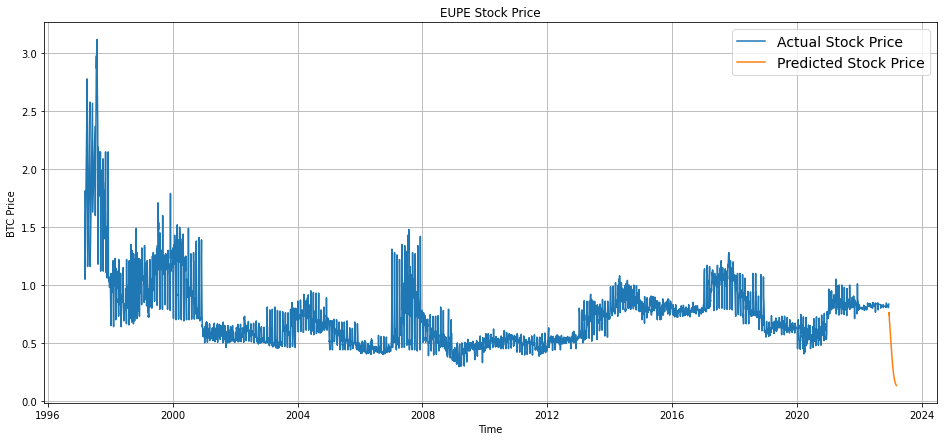

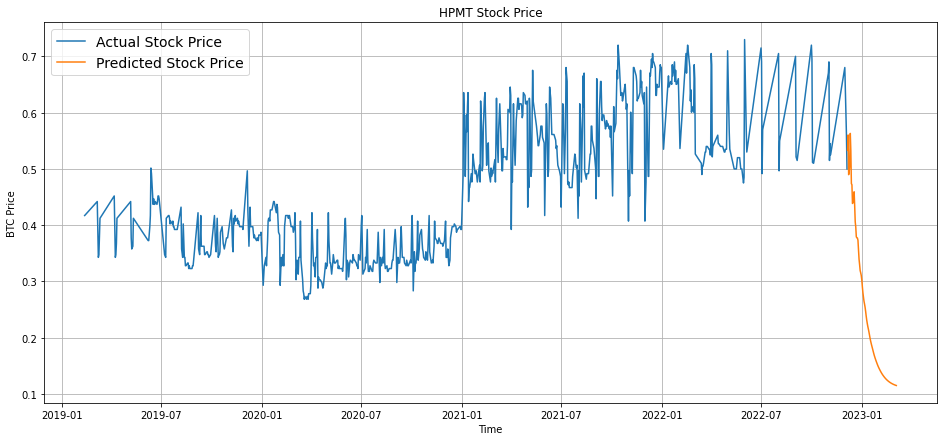

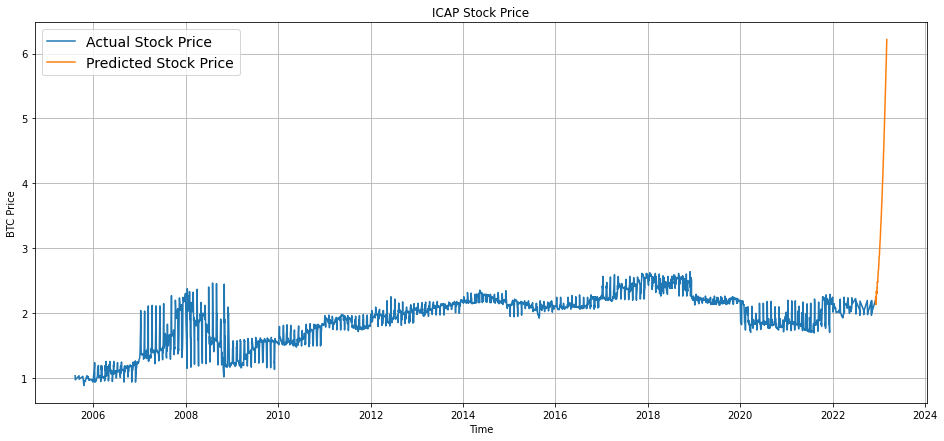

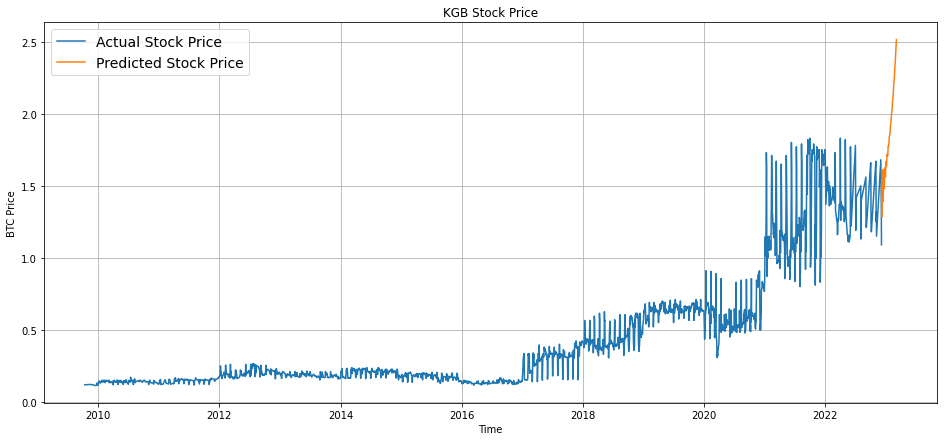

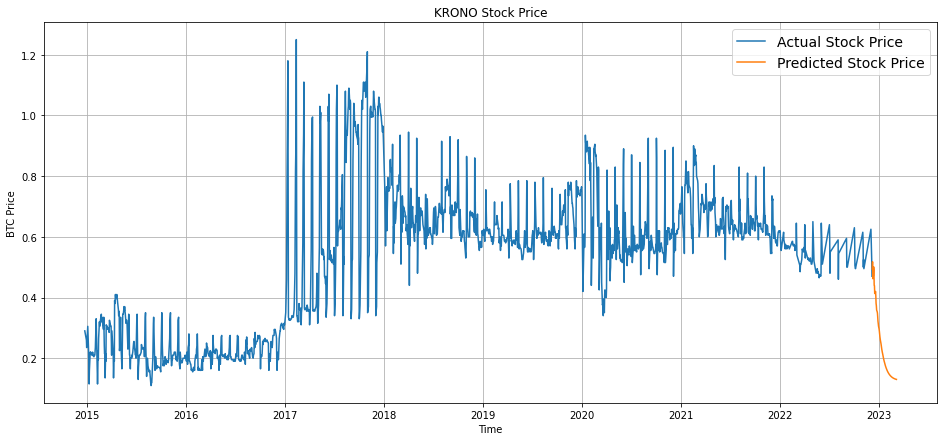

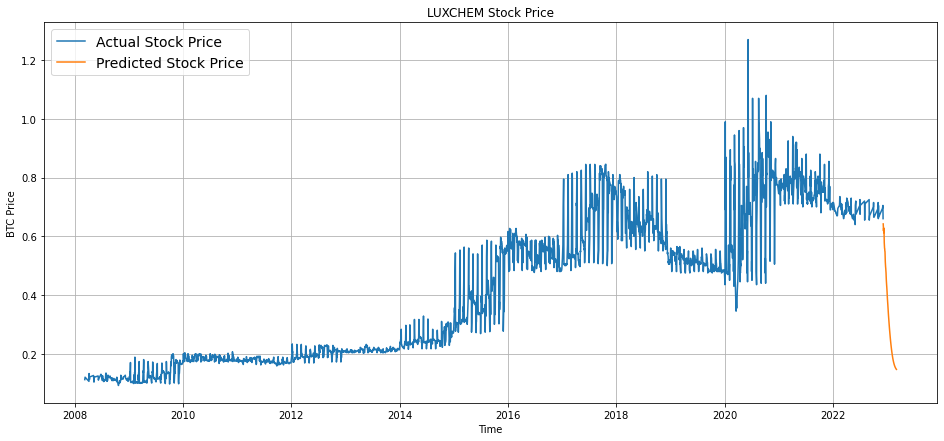

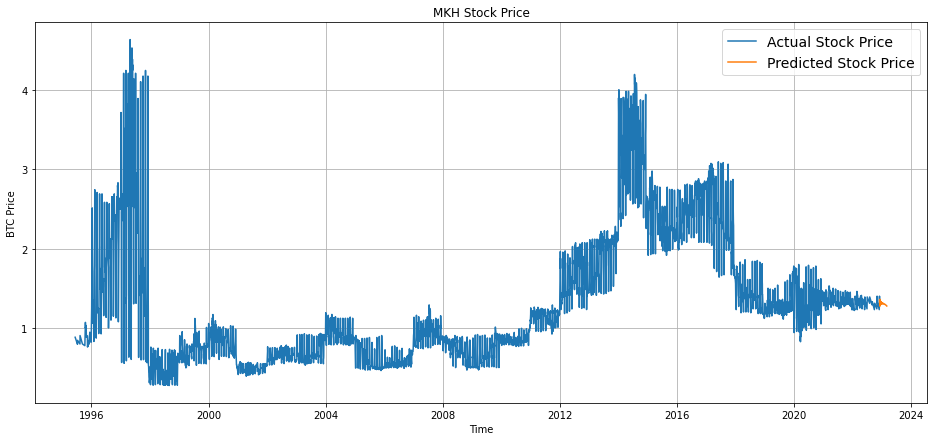

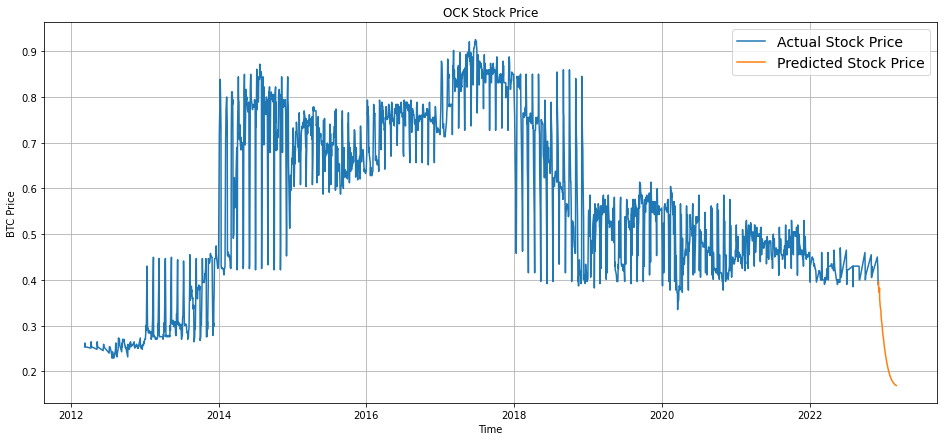

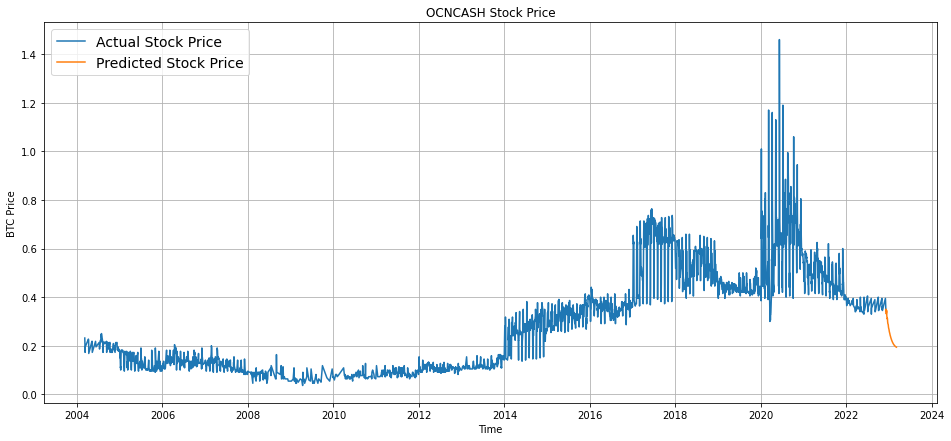

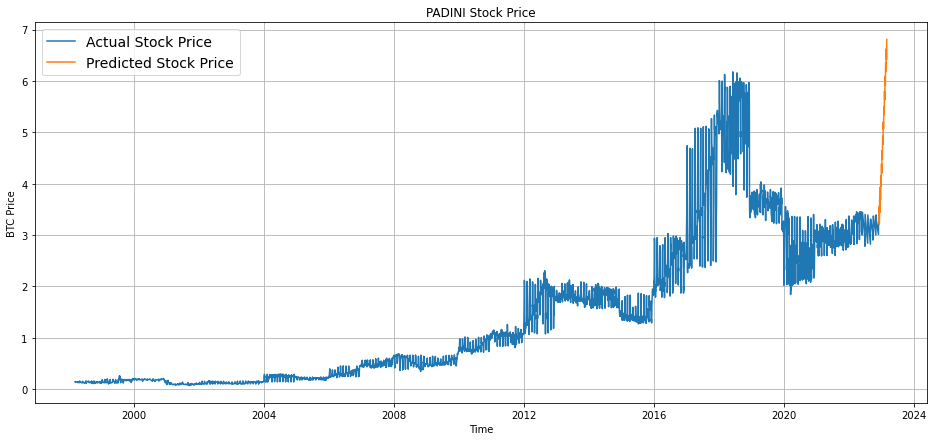

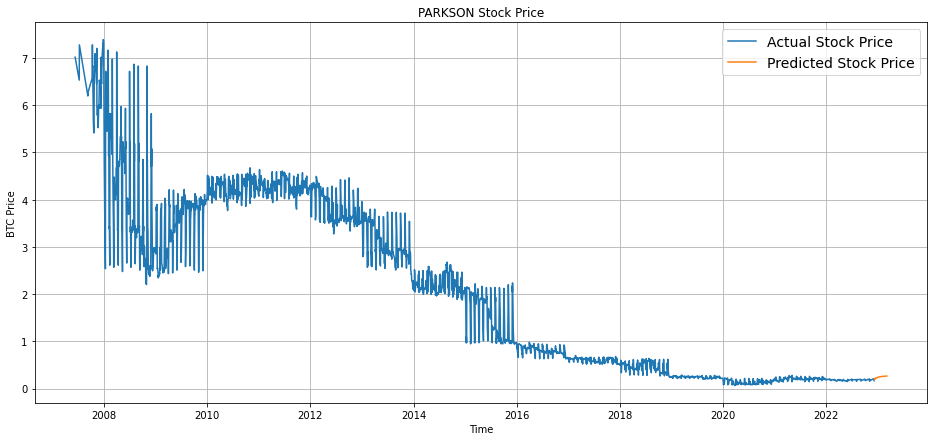

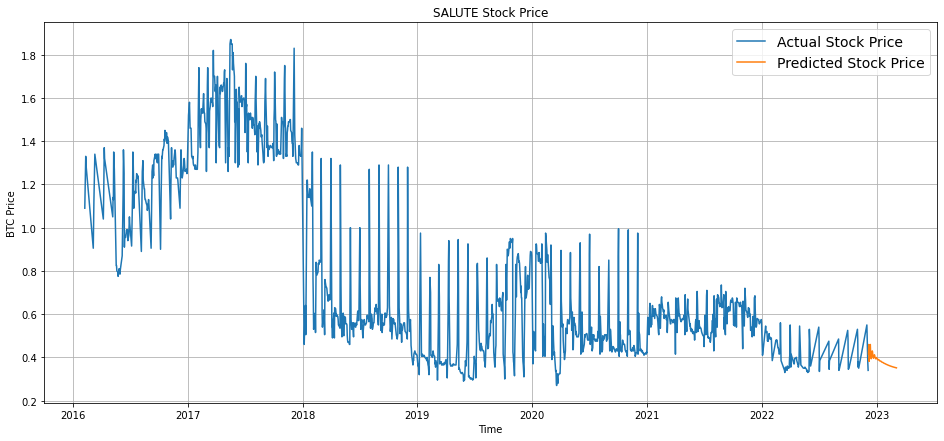

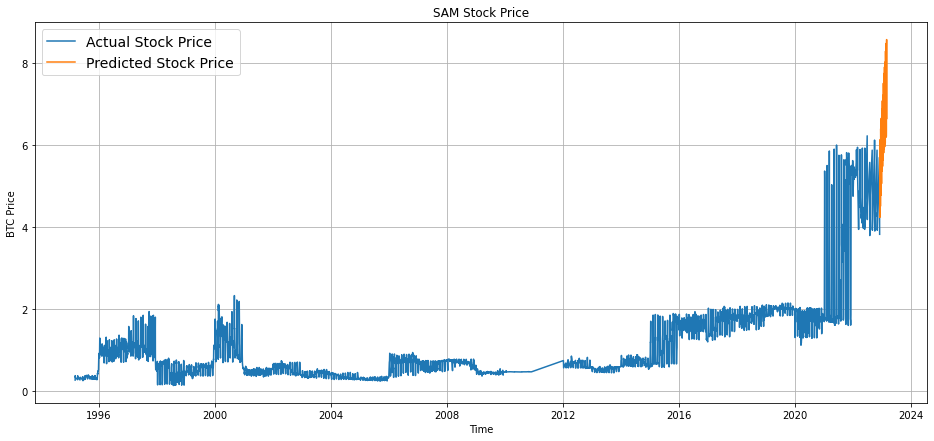

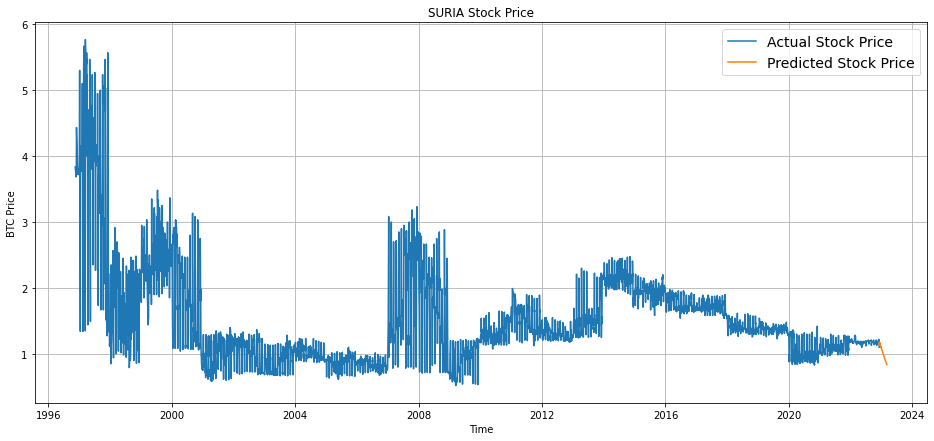

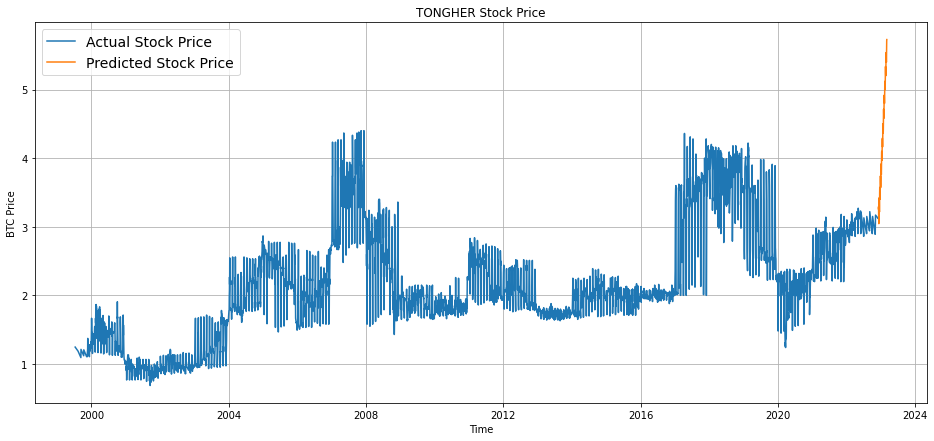

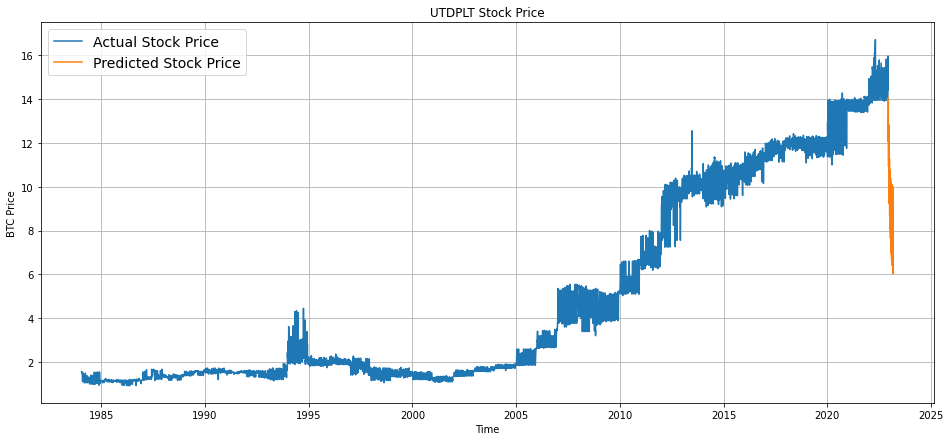

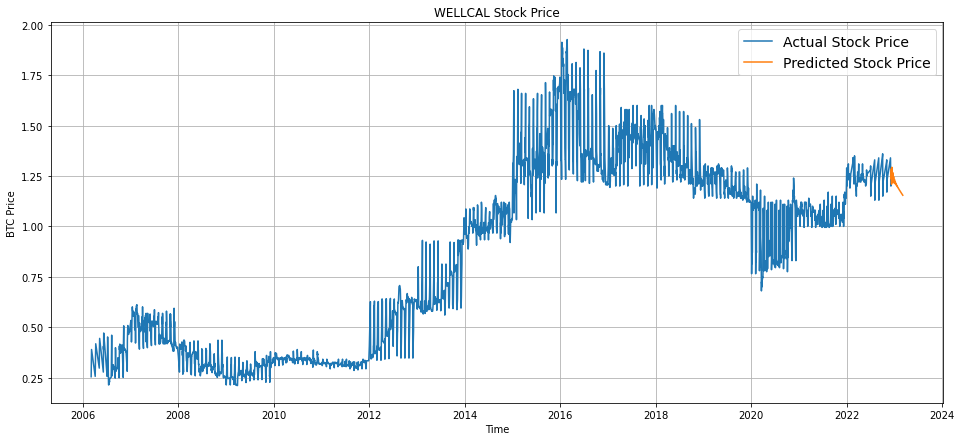

In [25]:
for s in future_forecast:
    # TIMESTEPS = np.insert(TIMESTEPS[s], 0, stock[s]['Date'].iloc[-1])
    # future_forecast = np.insert(future_forecast[s], 0, stock[s]['Close'].iloc[-1])
    plt.figure(figsize=(16, 7))
    plt.title(f"{s} Stock Price")
    utils.plot_time_series(stock[s]['Date'], stock[s]['Close'], format="-", label="Actual Stock Price")
    utils.plot_time_series(TIMESTEPS[s], future_forecast[s], format="-", label="Predicted Stock Price")
    plt.show()
